<b> <font size="6"> PA006: Credit Card Dataset for Clustering </font></b>

# Imports

In [1]:
import pandas as pd
import numpy as np
import inflection
from IPython.core.display  import HTML
from sklearn import metrics as mt
from sklearn import preprocessing as pp

# EDA
from pandas_profiling import ProfileReport
import sweetviz as sv

# visualization
from matplotlib import pyplot as plt
import seaborn as sns

# Models
from sklearn import ensemble as en
from sklearn import cluster as cl
from sklearn import mixture as mx

# Reducers
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA as kpca
from sklearn               import manifold as mn
import umap.umap_ as umap

## Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [15, 10]
    plt.rcParams['font.size'] = 25
    
    display(HTML( '<style>.container {width:100% !important;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
            
    sns.set()
    
jupyter_settings ()

Populating the interactive namespace from numpy and matplotlib


## Loading data

In [3]:
df_raw = pd.read_csv('C:/Users/DML1WFE/repos/projects/pa006_bank_marketing_strategy/bank_marketing_stretegy/data/raw/CCGENERAL.csv')

# Data Description

In [4]:
df01 = df_raw.copy()

## Columns Rename

In [5]:
old_cols = ['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
            'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
            'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
            'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
            'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
            'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, old_cols))

#rename
df01.columns = cols_new

## Data Dimensions

In [6]:
print ('Number of rows: {}'.format(df01.shape[0]))
print ('Number os columns:{}'.format(df01.shape[1]))

Number of rows: 8950
Number os columns:18


## Data Types

In [7]:
df01.dtypes

cust_id                              object
balance                             float64
balance_frequency                   float64
purchases                           float64
oneoff_purchases                    float64
installments_purchases              float64
cash_advance                        float64
purchases_frequency                 float64
oneoff_purchases_frequency          float64
purchases_installments_frequency    float64
cash_advance_frequency              float64
cash_advance_trx                      int64
purchases_trx                         int64
credit_limit                        float64
payments                            float64
minimum_payments                    float64
prc_full_payment                    float64
tenure                                int64
dtype: object

## Check Missing Values

In [8]:
df01.isna().sum() / df01.shape[0] * 100

cust_id                             0.000000
balance                             0.000000
balance_frequency                   0.000000
purchases                           0.000000
oneoff_purchases                    0.000000
installments_purchases              0.000000
cash_advance                        0.000000
purchases_frequency                 0.000000
oneoff_purchases_frequency          0.000000
purchases_installments_frequency    0.000000
cash_advance_frequency              0.000000
cash_advance_trx                    0.000000
purchases_trx                       0.000000
credit_limit                        0.011173
payments                            0.000000
minimum_payments                    3.497207
prc_full_payment                    0.000000
tenure                              0.000000
dtype: float64

## Replace Missing Values

In [9]:
df01 = df01.dropna()

In [10]:
df01.isna().sum()

cust_id                             0
balance                             0
balance_frequency                   0
purchases                           0
oneoff_purchases                    0
installments_purchases              0
cash_advance                        0
purchases_frequency                 0
oneoff_purchases_frequency          0
purchases_installments_frequency    0
cash_advance_frequency              0
cash_advance_trx                    0
purchases_trx                       0
credit_limit                        0
payments                            0
minimum_payments                    0
prc_full_payment                    0
tenure                              0
dtype: int64

## Descriptive Statistics

In [11]:
num_attributes = df01.select_dtypes(include = ['float64', 'int64'])
cat_attributes = df01.select_dtypes(exclude = ['float64', 'int64', 'datetime64[ns]'])

### Numerical Attributes

In [12]:
# estimadores de localicação
est1 = pd.DataFrame(num_attributes.apply(np.mean)).T
est2 = pd.DataFrame(num_attributes.apply(np.median)).T
est3 = pd.DataFrame(num_attributes.apply(np.min)).T
est4 = pd.DataFrame(num_attributes.apply(np.max)).T

# estimadores de variabilidade
est5 = pd.DataFrame(num_attributes.apply(np.std)).T
est6 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min())).T

# skewness and kurtosis
est7 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() )).T
est8 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis())).T

# conatenate
m1 = pd.concat([est3, est4, est6, est1, est2, est5, est7, est8]).T.reset_index()
m1.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std deviation', 'skewness', 'kurtosis']
m1

# percentis
quartis = num_attributes.apply( lambda x: np.quantile( x, q=[0.10, 0.25, 0.50, 0.75, 0.95, 0.99])).T.reset_index()
quartis.columns = ['attributes', 'P10', 'P25', 'P50', 'P75', 'P95', 'P99']

#
m2 = pd.merge(m1, quartis, how='inner', on='attributes')
m2

,attributes,min,max,range,mean,median,std deviation,skewness,kurtosis,P10,P25,P50,P75,P95,P99
0,balance,0.000000,19043.13856,19043.138560,1601.224893,916.855459,2095.449969,2.374254,7.553876,29.093764,148.095189,916.855459,2105.195853,5936.635587,9369.550879
1,balance_frequency,0.000000,1.00000,1.000000,0.895035,1.000000,0.207685,-2.084161,3.369586,0.545455,0.909091,1.000000,1.000000,1.000000,1.000000
2,purchases,0.000000,49039.57000,49039.570000,1025.433874,375.405000,2166.982511,8.055789,108.677684,0.000000,43.367500,375.405000,1145.980000,4060.092500,9127.092000
3,oneoff_purchases,0.000000,40761.25000,40761.250000,604.901438,44.995000,1684.210284,9.935776,160.121308,0.000000,0.000000,44.995000,599.100000,2728.372500,6783.896500
4,installments_purchases,0.000000,22500.00000,22500.000000,420.843533,94.785000,917.192075,7.216133,94.193373,0.000000,0.000000,94.785000,484.147500,1800.000000,3916.483000
5,cash_advance,0.000000,47137.21176,47137.211760,994.175523,0.000000,2121.335473,5.139629,52.143523,0.000000,0.000000,0.000000,1132.385490,4721.415498,9681.634354
6,purchases_frequency,0.000000,1.00000,1.000000,0.496000,0.500000,0.401249,0.033041,-1.638001,0.000000,0.083333,0.500000,0.916667,1.000000,1.000000
7,oneoff_purchases_frequency,0.000000,1.00000,1.000000,0.205909,0.083333,0.300036,1.504234,1.058206,0.000000,0.000000,0.083333,0.333333,1.000000,1.000000
8,purchases_installments_frequency,0.000000,1.00000,1.000000,0.368820,0.166667,0.398070,0.487753,-1.419279,0.000000,0.000000,0.166667,0.750000,1.000000,1.000000
9,cash_advance_frequency,0.000000,1.50000,1.500000,0.137604,0.000000,0.201780,1.795915,3.184233,0.000000,0.000000,0.000000,0.250000,0.583333,0.833333


# Data Filtering

In [13]:
df02 = df01.copy()

# Feature Engineering

In [14]:
df03 = df02.copy()

In [15]:
## pagamento a vista ou não
#df30['one_payment'] = df30['oneoff_purchases'].apply(lambda x: 0 if x == 0.00 else 1)
#
## valor medio transação de compra
#df30['avg_ticket_purchase'] = df30['purchases'] / df30['purchases_trx']
#
# Gasto médio por transação de compra totais
#df03['avg_ticket_expenses'] = df03['purchases'] / df03['purchases_trx']
#
##soma das despesas / soma dos pagamentos
#df30['debt_rate'] = (df30['purchases'] + df30['cash_advance']) / (df30['payments'] + df30['minimum_payments'])
#
## percentual de uso do limite dos cartão
#df30['credit_limit_rate'] = df30['purchases'] + df30['cash_advance'] / 6 * (df30['credit_limit'])
#
#df03 = df03.replace([np.inf, -np.inf], 0.0)

In [16]:
#df03.sort_values(['avg_ticket_expenses'],ascending=True).head(50)

# Exploratory Data Analysis

## Univariate Analysis

In [17]:
df04 = df03.copy()

### Pandas Profiling

In [18]:
#profile = ProfileReport(df01, title = 'Credit Card Dataset for Clustering')
#profile.to_file("C:/Users/dml1wfe/repos/projects/pa006_bank_marketing_strategy/bank_marketing_stretegy/reports/profiling_report.html")

### SweetViz

In [19]:
#analysis = sv.analyze(df04)
#analysis.show_html("C:/Users/dml1wfe/repos/projects/pa006_bank_marketing_strategy/bank_marketing_stretegy/reports/sweetviz_report.html")

### Notes

* balance
    * 75% das clientes possuem saldo disponivel para compras até $ 2.500
    
    
* balance_frequency
    * a frequencia de atualização do saldo disponivel para compas é alto
    
    
* purchases
    * 22% dos clientes nao fizeram compras nos ultimos 6 meses
    
    
* oneoff_purchases
    * 48% dos clientes os ultimos 6 meses nao fizeram um one off purchases
    
    
* installments_purchases
    * 75% dos usam essa modalidade para compras ate $ 500, no entanto 43% nao realizaram compras nessa modalidade
    

* cash_advance
    * 51% dos clientes nao utilizaram essa modalidade
    * exite um cliente que utilizou 47 mil desta modalidade (123 trx)


* purchases_frequency
    * 22% dos clientes nao fizeram compras nos ultimos 6 meses


* oneoff_purchases_frequency
    * 48% dos clientes os ultimos 6 meses nao fizeram um one off purchases
    * alta correlação com oneoff_purchases


* purchases_installments_frequency
    * 43% nao realizaram compras nessa modalidade
    * alta correlação com installments_purchases


* cash_advance_frequency
 * 51% dos clientes nao utilizaram essa modalidade
 * alta correlação com cash_advance


* cash_advance_trx ->


* purchases_trx ->


* credit_limit ->


* payments ->


* minimum_payments ->


* prc_full_payment ->


* tenure ->

## Bivariate Analysis

In [20]:
#sns.pairplot(df04.drop(columns = 'cust_id'))

# Data Preparation

In [21]:
df05 = df04.drop('cust_id', axis = 1)

cols = df05.columns

for col in cols:
    df05[col] = np.log(1 + df05[col])

In [22]:
# variavel normal + sem outlier -> standard scaler (x - mean / std)
# variavel normal + com outlier -> robust scaler (x - Q1 / ( Q3 - Q1))
# variavel não normal           -> min max scaler (x - min / (max - min)) 

In [23]:
#mm = pp.MinMaxScaler()
##
#df05['balance'] = mm.fit_transform(df05[['balance']])
#df05['purchases'] = mm.fit_transform(df05[['purchases']])
#df05['oneoff_purchases'] = mm.fit_transform(df05[['oneoff_purchases']])
#df05['installments_purchases'] = mm.fit_transform(df05[['installments_purchases']])
#df05['cash_advance'] = mm.fit_transform(df05[['cash_advance']])
#df05['cash_advance_trx'] = mm.fit_transform(df05[['cash_advance_trx']])
#df05['purchases_trx'] = mm.fit_transform(df05[['purchases_trx']])
#df05['credit_limit'] = mm.fit_transform(df05[['credit_limit']])
#df05['payments'] = mm.fit_transform(df05[['payments']])
#df05['minimum_payments'] = mm.fit_transform(df05[['minimum_payments']])
#df05['tenure'] = mm.fit_transform(df05[['tenure']])
##df05['avg_ticket_expenses'] = mm.fit_transform(df05[['avg_ticket_expenses']])



# Data Space Study

In [24]:
df06 = df05.copy()

## Principal Component Analysis (PCA)

In [25]:
pca = PCA(n_components = df06.shape[1])
pca_space = pca.fit_transform(df06)

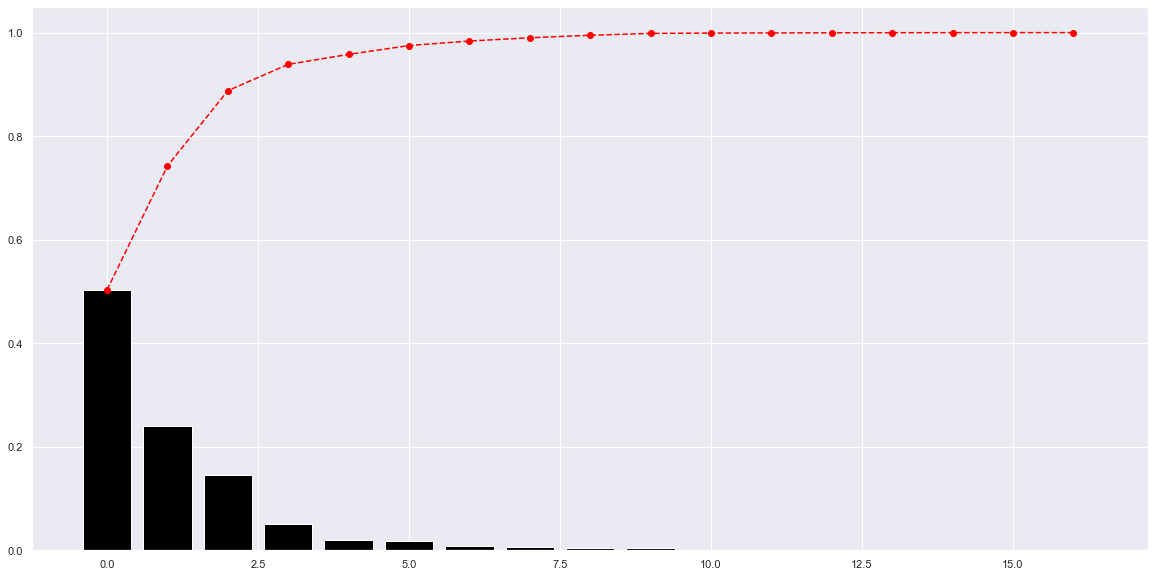

In [26]:
features = range(pca.n_components)
plt.figure(figsize=(20,10))
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.plot (features, pca.explained_variance_ratio_.cumsum(), color='red', linestyle='--', marker='o');

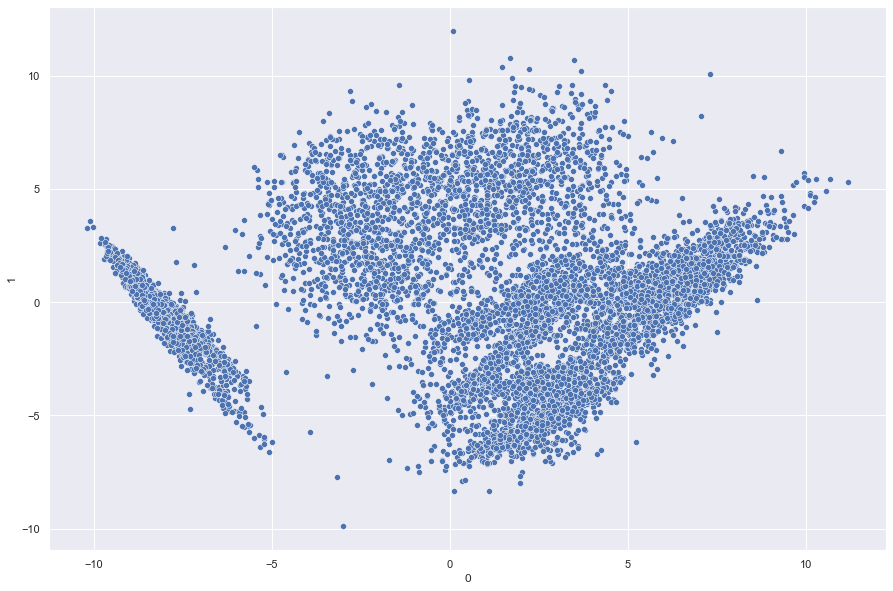

In [27]:
df_pca = pd.DataFrame (pca_space)
sns.scatterplot( x = 0, y = 1, data = df_pca);

## Kernel PCA

In [28]:
kernel_pca = kpca( n_components = 2, kernel = 'rbf', gamma = 10, fit_inverse_transform = True, alpha = 0.1 )
kernel_space = kernel_pca.fit_transform(df06)

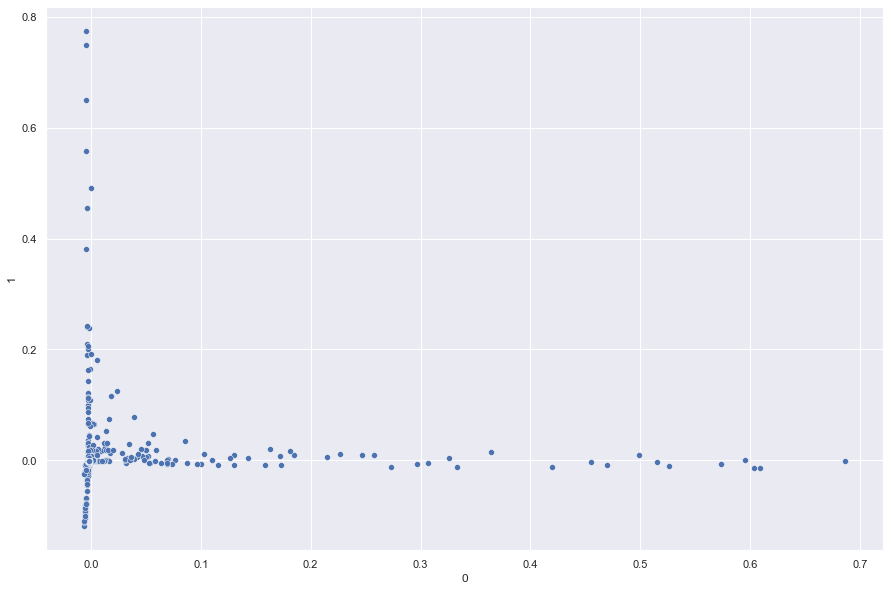

In [29]:
df_kernel_space = pd.DataFrame (kernel_space)
sns.scatterplot( x = 0, y = 1, data = df_kernel_space);

## Uniform Manifold Approximation and Projection (UMAP)

In [30]:
reducer = umap.UMAP(n_components = 4, n_neighbors=30,random_state=42 )
embedding_umap = reducer.fit_transform(df06)

# plot UMAP
sns.scatterplot( x= embedding[ :, 0], y = embedding[ :, 1])

NameError: name 'embedding' is not defined

## T-distributed Stochastic Neighbor Embedding (TSNE)

In [ ]:
reducer = mn.TSNE(n_components = 2, n_jobs = -1,perplexity = 150, learning_rate = 'auto', random_state=42)
embedding = reducer.fit_transform(df06)

# plot UMAP
sns.scatterplot( x= embedding[ :, 0], y = embedding[ :, 1]);

## Tree-Based Embedding

In [ ]:
# split the predictor and target variables
y = df06['purchases']
X = df06.drop('purchases', axis = 1)

# model definition
rf_model = en.RandomForestRegressor(n_estimators = 1500 , random_state = 42)

# model fit
rf_model.fit(X, y)

# Leaf DataFrame
df_leafs = pd.DataFrame (rf_model.apply (X))

### UMAP - Tree-Based Embedding

In [ ]:
# Reducer dimensionality - UMAP
reducer = umap.UMAP(n_components = 2,random_state=42, n_neighbors=30)
embedding_tb_umap = reducer.fit_transform(df_leafs)

# plot UMAP
sns.scatterplot( x= embedding_tb_umap[ :, 0], y = embedding_tb_umap[ :, 1]);

### TSNE - Tree-Based Embedding

In [ ]:
# Reducer dimensionality - TSNE
reducer = mn.TSNE(n_components = 2, n_jobs = -1,perplexity = 150, learning_rate = 'auto', random_state=42)
embedding_tsne_umap = reducer.fit_transform(df_leafs)

# plot UMAP
sns.scatterplot( x= embedding_tsne_umap[ :, 0], y = embedding_tsne_umap[ :, 1]);

# Feature Selection

In [ ]:
#df07 = df_leafs.copy()

In [ ]:
#df07.shape

# Hyperparameter Fine-Tunning

In [ ]:
#df08 = df_leafs.copy()
#df08 = df06.copy()
#df08 = pd.DataFrame(embedding_tb_umap)
df08 = pd.DataFrame(embedding_umap)

## Training Isolation Forest

In [ ]:
#model = en.IsolationForest(random_state=42)
#
#param_grid = {'n_estimators': [1000, 1500], 
#              'max_samples': [10], 
#              'contamination': ['auto', 0.02, 0.03], 
#              'max_features': [10, 15], 
#              'bootstrap': [True], 
#              'n_jobs': [-1]}
#
#grid_search = model_selection.GridSearchCV(model, 
#                                           param_grid,
#                                           scoring="neg_mean_squared_error", 
#                                           refit=True,
#                                           cv=10, 
#                                           return_train_score=True)
#grid_search.fit(df08)
#
#best_model = grid_search.fit(df08)
#print('Optimum parameters', best_model.best_params_)

In [ ]:
# model definition
iso_model = en.IsolationForest(n_jobs = -1, n_estimators=1500, contamination=0.5)

#model fit
iso_model.fit (df08.values)

# predict
pred = iso_model.predict(df08.values)
pred_scores = -1 * iso_model.score_samples(df08.values)

# outlier detector
df08['outlier'] = pred_scores

In [ ]:
df08.sort_values(by ='outlier', ascending = False).head(10)

In [ ]:
df08.sort_values(by ='outlier', ascending = True).head(10)

## Removing Outliers

In [ ]:
df082 = df08.copy()

In [ ]:
threshold = 0.55
df082['outlier_flag'] = df082['outlier'].apply(lambda x: 1 if x > threshold else 0 )
df082 = df082.loc[df082['outlier_flag'] == 0, :]

In [ ]:
print(f" Removidos {df08.shape[0] - df082.shape[0]} outliers, representando {round(((df08.shape[0] - df082.shape[0]) / df08.shape[0])*100,2)}% do dos dados.")

# Model Training

In [ ]:
df09 = df082.copy()

In [ ]:
clusters = list(range(2, 11))

## K-Means clustering (K-Means)

In [ ]:
silhouette_list = []
davies_list = []

for k in clusters:
    # model definition
    kmeans_model = cl.KMeans (n_clusters = k)

    # model training
    kmeans_model.fit(df09.values)

    # model predict
    labels_kmenas = kmeans_model.predict(df09.values)

    # model performance
    sil = mt.silhouette_score(df09, labels_kmenas)
    dav = mt.davies_bouldin_score(df09, labels_kmenas)
    silhouette_list.append(sil)
    davies_list.append(dav)
    
    # silhouette score
    print ("\nFor n_clusters = {0}: \nsilhouette score = {1}, DB Index = {2}".format(k, sil, dav))

In [ ]:
plt.figure( figsize=(15, 10 ))
plt.plot( clusters, silhouette_list, linestyle = '--', marker = 'o', color = 'b');
plt.xlabel('K - Number of clusters')
plt.ylabel( 'SS - Silhouette Sore')
plt.title( 'Silhouette Sore');

In [ ]:
plt.figure( figsize=(15, 10 ))
plt.plot( clusters, davies_list, linestyle = '--', marker = 'o', color = 'b');
plt.xlabel('K - Number of clusters')
plt.ylabel( 'DB Score')
plt.title( 'DB Index');

## Gaussian Mixture Model (GMM)

In [ ]:
silhouette_list = []
davies_list = []

for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture(n_components = k)

    # model training
    gmm_model.fit (df09.values)

    # model prediction
    labels_gmm = gmm_model.predict (df09.values)

    # model performance
    sil = mt.silhouette_score(df09.values, labels_gmm)
    dav = mt.davies_bouldin_score(df09.values, labels_gmm)
    silhouette_list.append(sil)
    davies_list.append(dav)
    
    # silhouette score
    print ("\nFor n_clusters = {0}: \nsilhouette score = {1}, DB Index = {2}".format(k, sil, dav))

In [ ]:
plt.figure( figsize=(15, 10 ))
plt.plot( clusters, silhouette_list, linestyle = '--', marker = 'o', color = 'b');
plt.xlabel('K - Number of clusters')
plt.ylabel( 'SS - Silhouette Sore')
plt.title( 'Silhouette Sore');

In [ ]:
plt.figure( figsize=(15, 10 ))
plt.plot( clusters, davies_list, linestyle = '--', marker = 'o', color = 'b');
plt.xlabel('K - Number of clusters')
plt.ylabel( 'DB Score')
plt.title( 'DB Index');

# Model Training

In [ ]:
k = 7

# model definition
kmeans_model = cl.KMeans (n_clusters = k)

# model training
kmeans_model.fit(df09.values)

# model predict
labels_kmeans = kmeans_model.predict(df09.values)

In [ ]:
## SS (Silhoutte Score) 
print('SS - Silhouette Score KMeans: {}'.format(mt.silhouette_score(df09, labels_kmeans, metric='euclidean')))

In [ ]:
df09['cluster_id'] = labels_kmeans
df09.head()

In [ ]:
#plot data with seaborn
sns.scatterplot(x = 0, y = 1, hue = 'cluster_id', data = df09, palette = 'Set1')
plt.show()

# Deploy to Production

## Cluster Validation

# Clustering Analysis

In [ ]:
df10 = df09.copy()
df10['labels'] = df_reducer['clusters']

In [ ]:
df_cluster

# EDA - Insight Reports

# Deploy to Production